# Assignment 2: Convolution and Canny edge detection
(Jim Neuendorf - 4588407, Manuel Heurich - 5176607)

## Exercise 2.1
Implement the convolution operation for 2-D images (i.e. no colors here, sorry). 

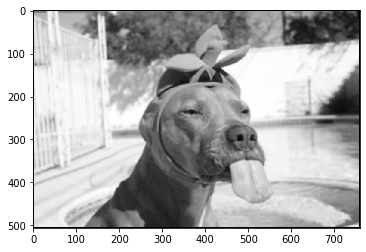

In [91]:
#%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg
from skimage import io, color


def conv2d(image, kernel, normalize=False):
    kernel_height, kernel_width = kernel.shape
    assert kernel_width % 2 != 0 and kernel_height % 2 != 0, 'kernel dimensions must but odd'
    kernel_sum = np.sum(np.fabs(kernel))

    image_height, image_width = image.shape
    convolved_image = np.zeros(image.shape)
    
    padding_x = kernel_width // 2
    padding_y = kernel_height // 2
    convolution_area = (
        (padding_y, image_height - padding_y), 
        (padding_x, image_width - padding_x)
    )
    def get_window(row, col):
        return (
            (row - padding_y, row + padding_y + 1), 
            (col - padding_x, col + padding_x + 1)
        )
    
    for row in range(*convolution_area[0]):
        for col in range(*convolution_area[1]):
            (y_min, y_max), (x_min, x_max) = get_window(row, col)
            area = image[y_min:y_max, x_min:x_max]
            convolved_image[row, col] = (area * kernel).sum() / kernel_sum
    
    if normalize:
        convolved_image = (
            (convolved_image - np.min(convolved_image)) 
            / np.ptp(convolved_image)
        )
    return convolved_image


image = color.rgb2gray(io.imread('images/dog.jpg'))

kernel = np.array([
    [2,  4,  5,  4, 2],
    [4,  9, 12,  9, 4],
    [5, 12, 15, 12, 5],
    [4,  9, 12,  9, 4],
    [2,  4,  5,  4, 2],
])

plt.imshow(conv2d(image, kernel), cmap='gray')


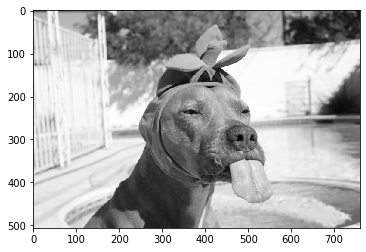

In [81]:
plt.imshow(image, cmap='gray')

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show your results (***RESULT***). 

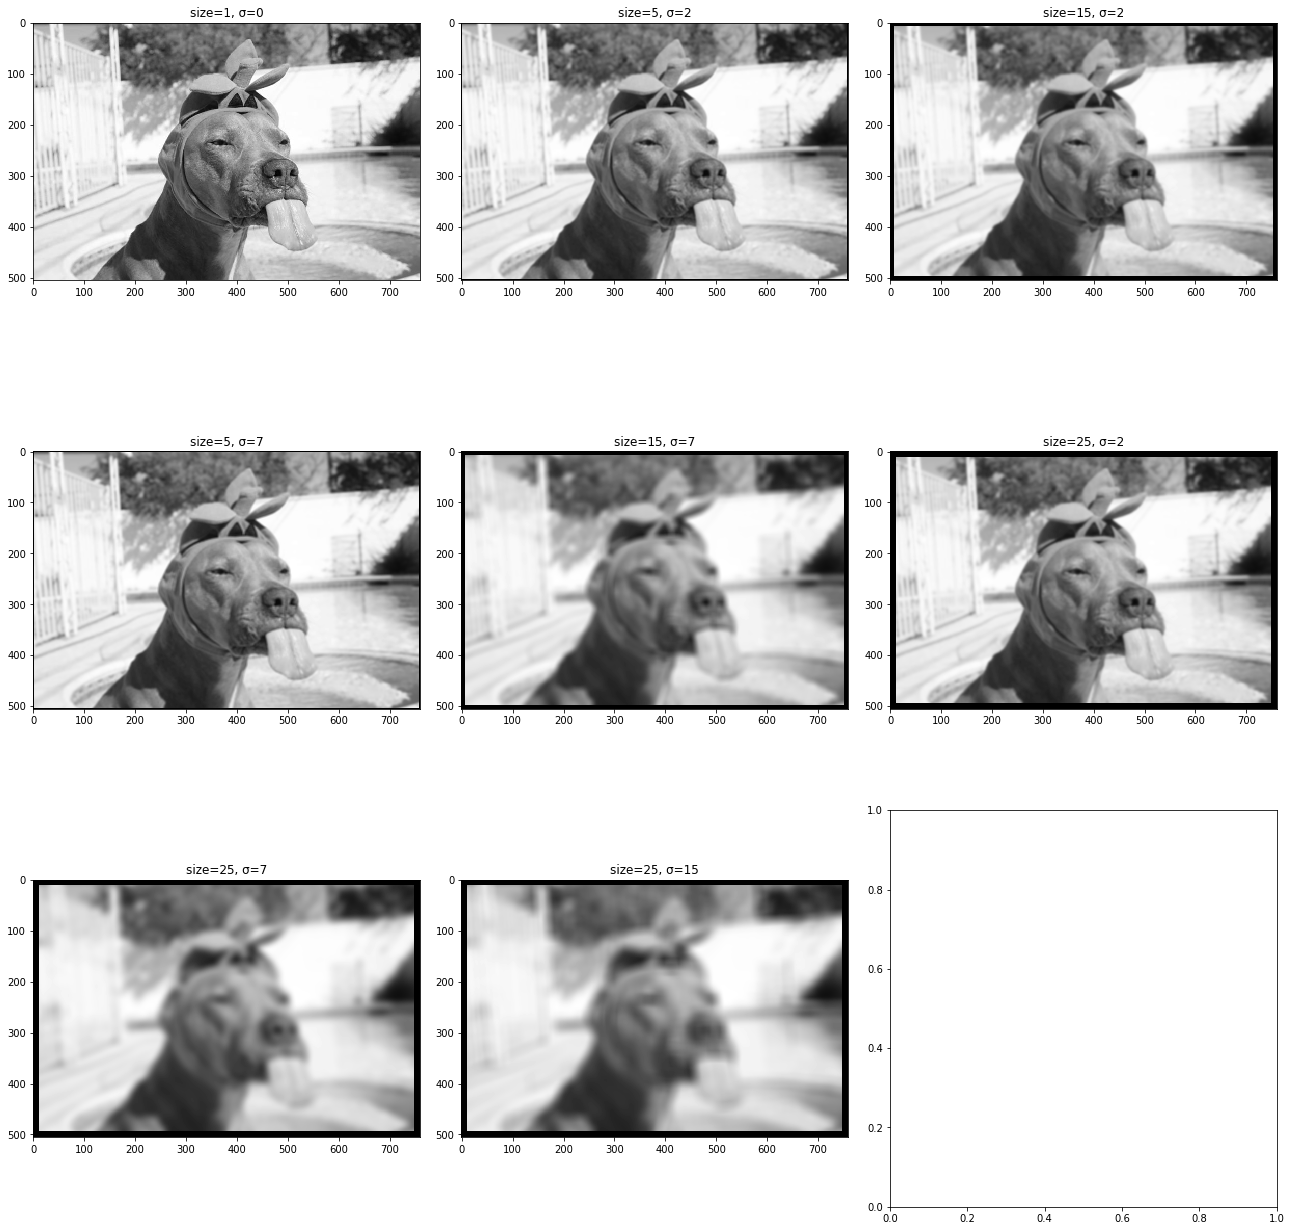

In [82]:
import numpy as np
from scipy import signal


def gaussian_kernel(size, standard_deviation):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(size, std=standard_deviation).reshape(size, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d


kernels = (
    # No-op for comparison.
    dict(size=1, standard_deviation=0),
    # Actually blurring kernels.
    dict(size=5, standard_deviation=2),
    dict(size=15, standard_deviation=2),
    dict(size=5, standard_deviation=7),
    dict(size=15, standard_deviation=7),
    dict(size=25, standard_deviation=2),
    dict(size=25, standard_deviation=7),
    dict(size=25, standard_deviation=15),
)



convolved_images = [
    conv2d(image, gaussian_kernel(**kernel))
    for kernel in kernels
]

fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_figheight(18)
fig.set_figwidth(18)
fig.tight_layout()
ax = np.asarray(axes).ravel()
for i, im in enumerate(convolved_images):
    ax[i].imshow(im, cmap='gray')
    try:
        kernel = kernels[i]
        ax[i].set_title(f'size={kernel["size"]}, σ={kernel["standard_deviation"]}')
    except IndexError:
        pass



Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

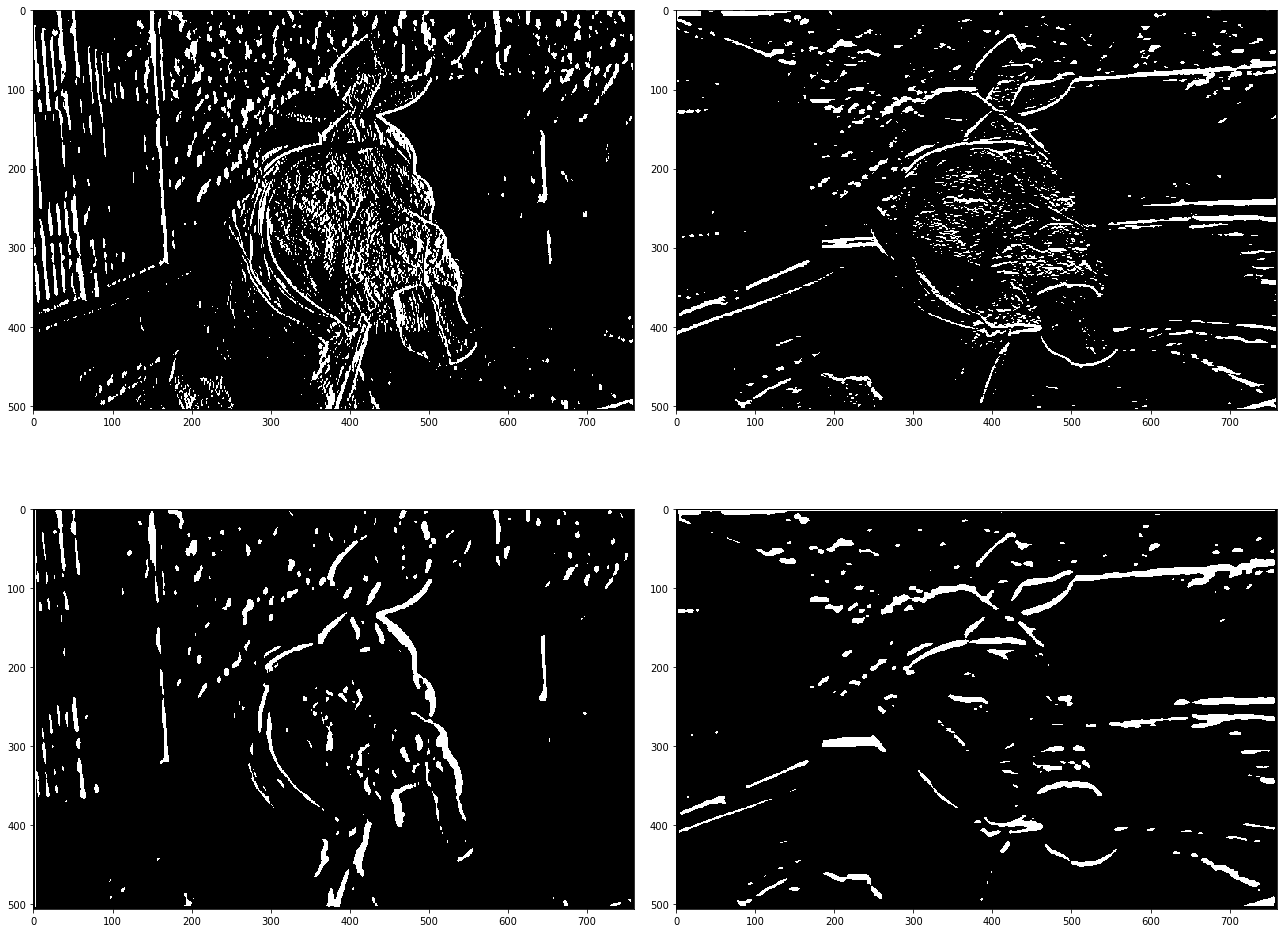

In [103]:
S_x = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1],
])
S_y = S_x.T
edges_vertical_unsmoothed = conv2d(image, S_x, normalize=True)
edges_horizontal_unsmoothed = conv2d(image, S_y, normalize=True)
smoothed = conv2d(image, gaussian_kernel(size=7, standard_deviation=3))
edges_vertical_smoothed = conv2d(smoothed, S_x, normalize=True)
edges_horizontal_smoothed = conv2d(smoothed, S_y, normalize=True)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(18)
fig.set_figheight(14)
fig.tight_layout()
ax = np.asarray(axes).ravel()

threshold = 0.52
for i, im in enumerate([
    edges_vertical_unsmoothed, edges_horizontal_unsmoothed, 
    edges_vertical_smoothed, edges_horizontal_smoothed,
]):
    thresholded = np.zeros(im.shape)
    idxs = im[:,:] > threshold
    thresholded[idxs] = threshold
    ax[i].imshow(thresholded, cmap='gray')

> As we can see, the results become less noisy when the input is smoothed beforehand. This reduces the work that needs to be done later.

## Exercise 1.2 Canny Edge Detection

### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices (see slides page 23). Round the gradient directions to the 8-neighbor's directions. Display all  intermediate ***RESULT***s!


gradient magnitudes
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.08875682 0.14062664 ... 0.04086172 0.02599542 0.        ]
 [0.         0.15196866 0.19626766 ... 0.0503062  0.03999585 0.        ]
 ...
 [0.         0.32386729 0.41092508 ... 0.43438464 0.34397669 0.        ]
 [0.         0.20582921 0.32662067 ... 0.34920937 0.22055585 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
exact angles
[[   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.           45.           63.39559678 ...  116.45253838
   135.            0.        ]
 [   0.           28.02086502   46.73779437 ...  135.52074379
   153.9641474     0.        ]
 ...
 [   0.          -26.47201402  -44.79764861 ... -135.36401937
  -153.69903802    0.        ]
 [   0.          -45.          -63.3661911  ... -116.59129844
  -135.            0.        ]
 [   0.            0.            0.         ...    0.
     0.

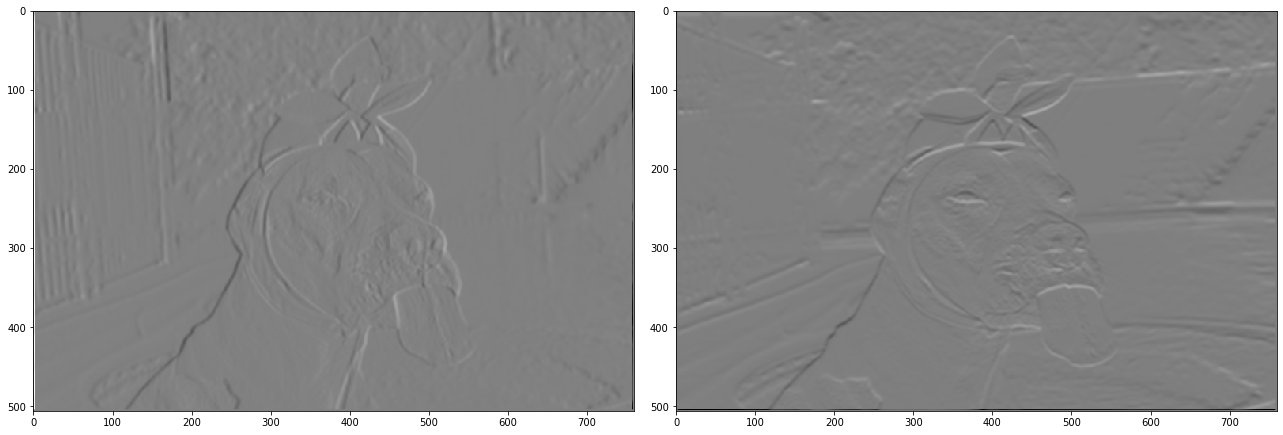

In [104]:
smoothed = conv2d(image, gaussian_kernel(size=5, standard_deviation=2))


def gradient_magnitudes_and_directions(image):
    """:param image: Should be the smoothed image."""

    S_x = np.array([
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1],
    ])
    S_y = S_x.T
    G_x = conv2d(smoothed, S_x, normalize=False)
    G_y = conv2d(smoothed, S_y, normalize=False)
    G = np.sqrt(np.square(G_x) + np.square(G_y))
    
    # Directions in the range [-pi, pi].
    # angles = np.arctan2(G_y, G_x)

    angles = np.degrees(np.arctan2(G_y, G_x))

    # Add a little bit to the last upper bin boundary because numpy checks for
    # lower <= x < upper
    # and we want np.pi to be in the last bin.
    # We could actually use any number because np.pi is the maximum
    # possible value returned from np.arctan2.
    bins = np.linspace(-180, 180, num=9)
    # Get bin indices.
    indices = np.digitize(angles, bins)
    # print(indices)
    # print(bins)
    theta = np.zeros(angles.shape)
    # If an output is exactly np.pi then the index would be 8 so we use index 0 
    # because -np.pi corresponds to np.pi
    theta[:] = bins[(indices[:] - 1) % 8]
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_figheight(18)
    fig.set_figwidth(18)
    fig.tight_layout()
    ax = np.asarray(axes).ravel()
    for i, im in enumerate([G_x, G_y]):
        ax[i].imshow(im, cmap='gray')
    
    print('gradient magnitudes')
    print(G)
    print('exact angles')
    print(angles)
    print('rounded angles')
    print(theta)
    
    return G, theta


G, theta = gradient_magnitudes_and_directions(smoothed)


### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

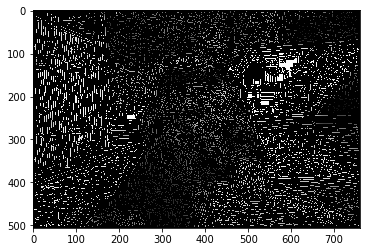

In [105]:
neighbors_by_direction = {
    0:   ( (0, +1),  (0, -1)  ),  # pointing downward
    45:  ( (-1, +1), (+1, -1) ),
    90:  ( (-1, 0),  (+1, 0)  ),  # pointing right
    135: ( (-1, -1), (+1, +1) ),
}
# neighbors_by_direction[180] = neighbors_by_direction[0]
# neighbors_by_direction[-180] = neighbors_by_direction[0]
# neighbors_by_direction[-135] = neighbors_by_direction[45]
# neighbors_by_direction[-90] = neighbors_by_direction[90]
# neighbors_by_direction[-45] = neighbors_by_direction[135]


def non_max_suppression(image, G, theta):
    suppressed = np.copy(image)
    for row in range(G.shape[0]):
        for col in range(G.shape[1]):
            magnitude = G[row,col]
            if magnitude == 0:
                suppressed[row,col] = 0
                continue
                
            direction = theta[row,col]
            (y1, x1), (y2, x2) = neighbors_by_direction[direction % 180]
            neighbors = (G[row+y1,col+x1], G[row+y2,col+x2])
            if magnitude < np.max(neighbors):
                suppressed[row,col] = 0
    return suppressed

thinned_edges = non_max_suppression(smoothed, G, theta)
plt.imshow(thinned_edges, cmap='gray')

### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)


In [106]:
thresholds = (
    (20, 50),
    (80, 120),
    (40, 140),
)